In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce
import ast

#For interactive plots 
import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate

In [5]:
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')


inflation_rate_df=get_inflation_rate()
franchise_df=get_franchise_movies(movies_df,inflation_rate_df,'data/missing_dates_manualsearch.csv')




franchise_data_df = get_franchise_data(franchise_df)
# average years between movies of a franchise
#franchise_data_df['average_years_bt_movies'] = franchise_data_df['franchise_length_years'] / (franchise_data_df['movie_count']-1)



In [23]:
franchise_df.dtypes

Wikipedia movie ID                                    int64
Freebase movie ID                                    object
Movie name                                           object
Movie release date                                   object
Movie runtime                                       float64
Movie languages (Freebase ID:name tuples)            object
Movie countries (Freebase ID:name tuples)            object
Movie genres (Freebase ID:name tuples)               object
tmdb_id                                             float64
collection_name                                      object
collection_id                                       float64
vote_count                                          float64
vote_average                                        float64
genres                                               object
budget                                              float64
run_time                                            float64
tmdb_origin_country                     

In [25]:
missing_dates = pd.read_csv('data/missing_dates_manualsearch.csv')
missing_dates.dropna(subset=['Movie release date'], inplace=True)
missing_dates.dtypes
missing_dates=missing_dates.astype({'Movie release date': 'int'})
missing_dates=missing_dates.astype({'Movie release date': 'str'})
missing_dates['date corrected']=pd.to_datetime(missing_dates['Movie release date'],format='mixed',yearfirst=True)


In [4]:
def count_genre_diff(curr, prev):
    if curr is None or prev is None:  # Handle NaN or None
        return 0
    curr_set, prev_set = set(curr), set(prev)
    return len(curr_set.symmetric_difference(prev_set))  # Count differences

# Apply the function while ensuring sorting
franchise_df['genre_diff'] = (
    franchise_df.groupby('collection_id', group_keys=False)
    .apply(
        lambda group: group.sort_values(by='movie_order')  # Sort locally
        .assign(
            genre_diff=lambda x: [
                count_genre_diff(curr, prev)
                for curr, prev in zip(x['genres'], x['genres'].shift(1))
            ]
        )
    )['genre_diff']  # Extract the 'genre_diff' column
    .reset_index(drop=True)  # Reset index to avoid misalignment
)

# difference relative de genre
franchise_df['genre_diff_rel'] = franchise_df['genre_diff'] / franchise_df['genres'].apply(len)

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_2225/3451685136.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


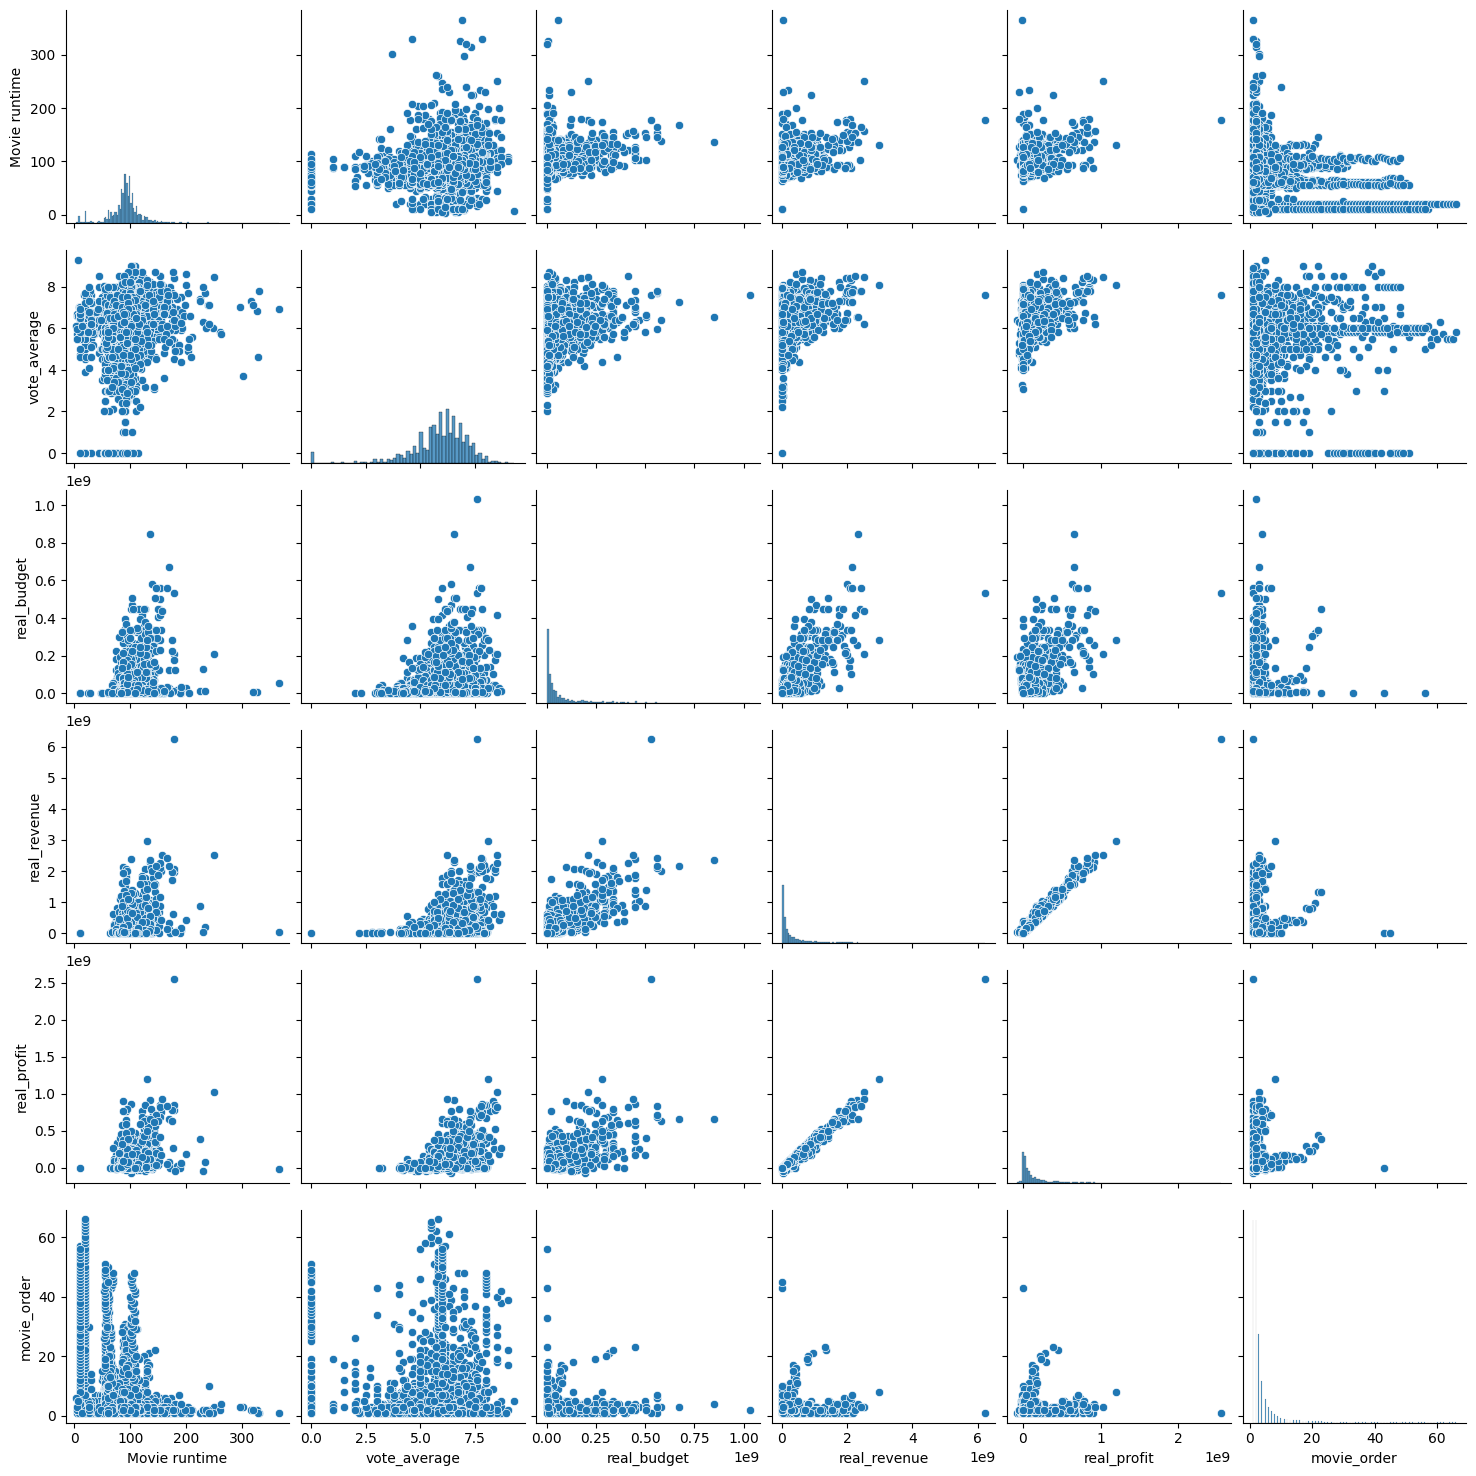

In [5]:
sns.pairplot(franchise_df[['Movie runtime','vote_average','real_budget','real_revenue','real_profit','movie_order']])

Text(0.5, 1.0, 'Pearson Correlation: 0.38\nSpearman Correlation: 0.40')

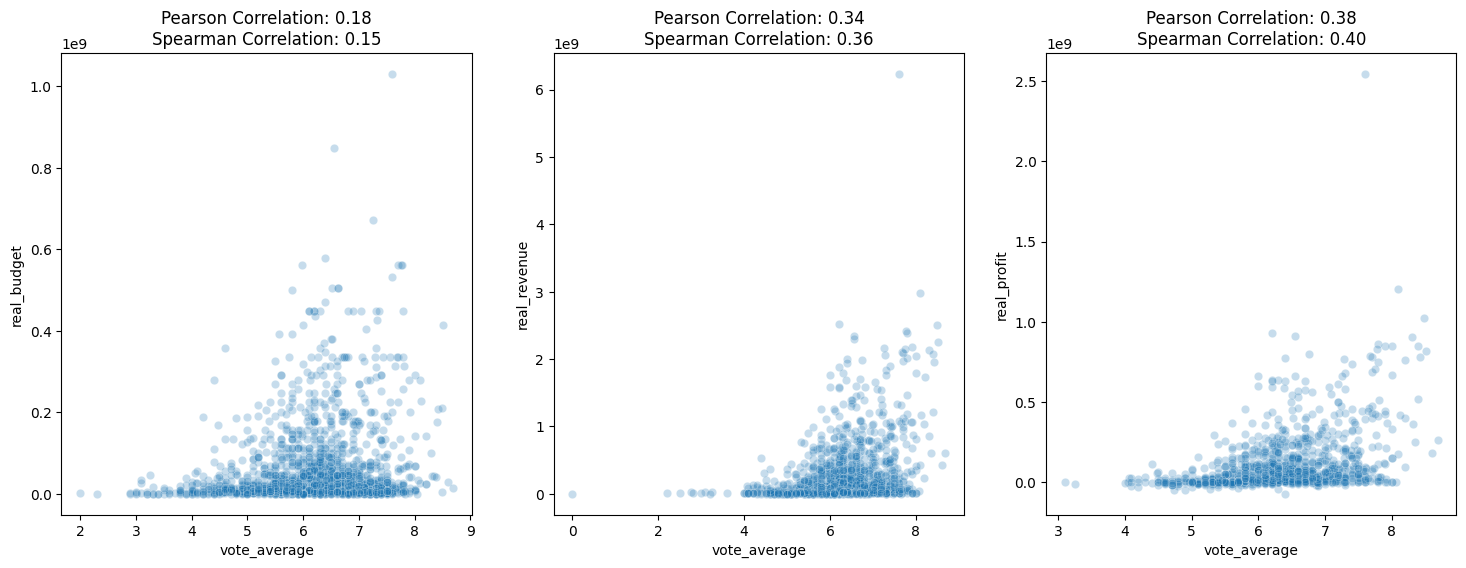

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and vote average
sns.scatterplot(x='vote_average', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and vote average
sns.scatterplot(x='vote_average', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and vote average
sns.scatterplot(x='vote_average', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['vote_average','real_budget','real_revenue','real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['vote_average','real_budget','real_revenue','real_profit']].corr(method='spearman')

axes[0].set_title(f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}')
axes[1].set_title(f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}')
axes[2].set_title(f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}')

Text(0.5, 1.0, 'Pearson Correlation: -0.04\nSpearman Correlation: -0.06')

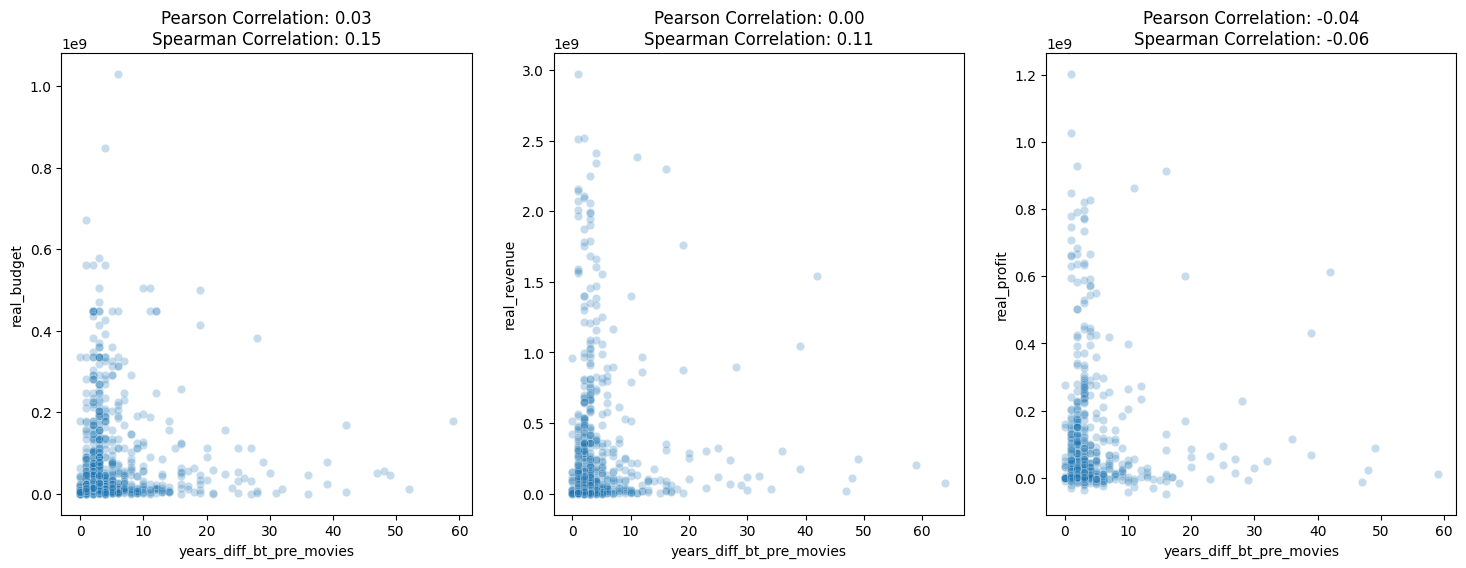

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='years_diff_bt_pre_movies', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='years_diff_bt_pre_movies', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='years_diff_bt_pre_movies', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['years_diff_bt_pre_movies','real_budget','real_revenue','real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['years_diff_bt_pre_movies','real_budget','real_revenue','real_profit']].corr(method='spearman')

axes[0].set_title(f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}')
axes[1].set_title(f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}')
axes[2].set_title(f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}')

Text(0.5, 1.0, 'Pearson Correlation: 0.08\nSpearman Correlation: 0.02')

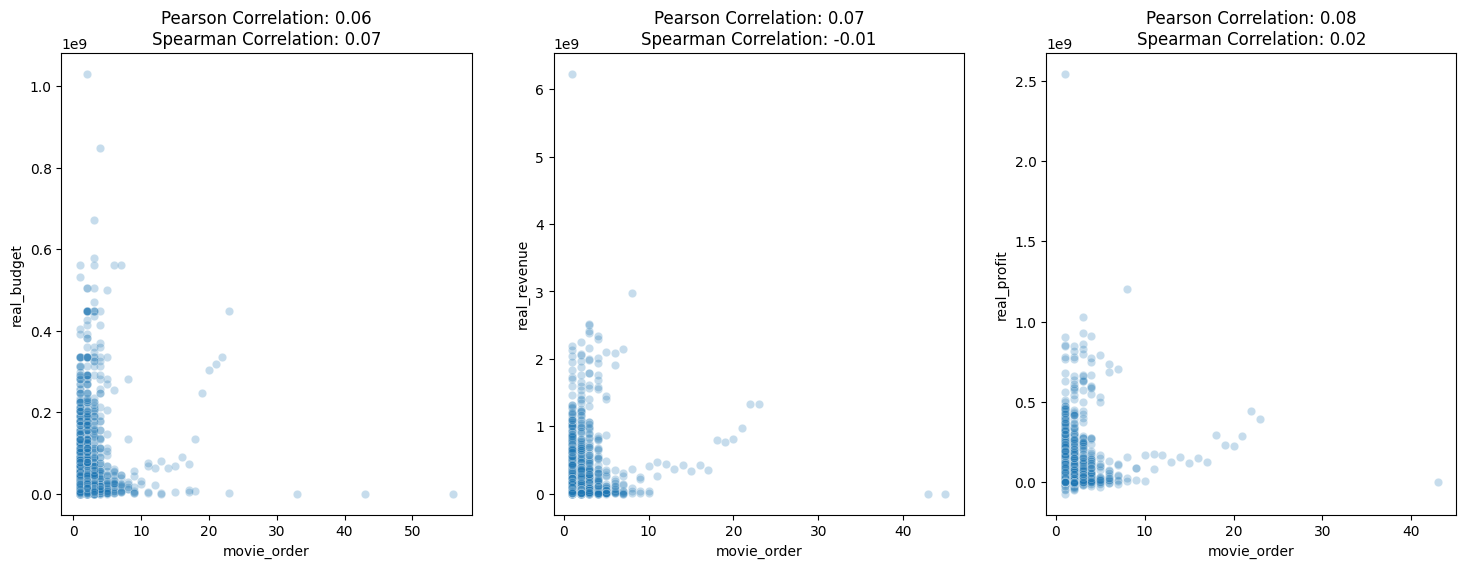

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and movie order
sns.scatterplot(x='movie_order', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and movie order
sns.scatterplot(x='movie_order', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and movie order
sns.scatterplot(x='movie_order', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['movie_order','real_budget','real_revenue','real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['movie_order','real_budget','real_revenue','real_profit']].corr(method='spearman')

axes[0].set_title(f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}')
axes[1].set_title(f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}')
axes[2].set_title(f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}')

In [9]:
# analysis of the difference between the first en second movies
fsm_df = franchise_df[(franchise_df['movie_order'] == 1) | (franchise_df['movie_order'] == 2)]
fsm_df = fsm_df[['Movie name','collection_name','movie_order','real_budget','real_revenue','real_profit','years_diff_bt_pre_movies','genre_diff','genre_diff_rel']]
fsm_df.sort_values(by='movie_order',inplace=True)
fsm_df['diff_profit_1_2'] = fsm_df.groupby('collection_name')['real_profit'].diff()
fsm_df['diff_budget_1_2'] = fsm_df.groupby('collection_name')['real_budget'].diff()
fsm_df['diff_revenue_1_2'] = fsm_df.groupby('collection_name')['real_revenue'].diff()
sm_df = fsm_df[fsm_df['movie_order'] == 2]
sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']
sm_df=sm_df.merge(fsm_df[(fsm_df['movie_order'] == 1)][['collection_name','real_profit']],on='collection_name',suffixes=('_movie2','_movie1'))
sm_df.dropna(subset=['diff_profit_1_2'],inplace=True)

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_2225/4279949577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']


In [10]:
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm



# Define the features and the label
X = sm_df[['real_budget','years_diff_bt_pre_movies','real_profit_movie1','diff_budget_1_2','genre_diff_rel']]
y = sm_df['profit_over_budget']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the features
X_train_std = StandardScaler().fit_transform(X_train)

X_test_std = StandardScaler().fit(X_train).transform(X_test)


# Add a constant to the features (intercept term)
X_train_std = sm.add_constant(X_train_std)

# Fit the regression model
model = sm.OLS(Y_train, X_train_std).fit()

# Print the summary of the regression model
print(model.summary())

results_table = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.params[1:],
    'P-value': model.pvalues[1:]
})
print(results_table)

                            OLS Regression Results                            
Dep. Variable:     profit_over_budget   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     5.044
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           0.000228
Time:                        18:03:45   Log-Likelihood:                -511.43
No. Observations:                 199   AIC:                             1035.
Df Residuals:                     193   BIC:                             1055.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5998      0.228      7.030      0.0

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


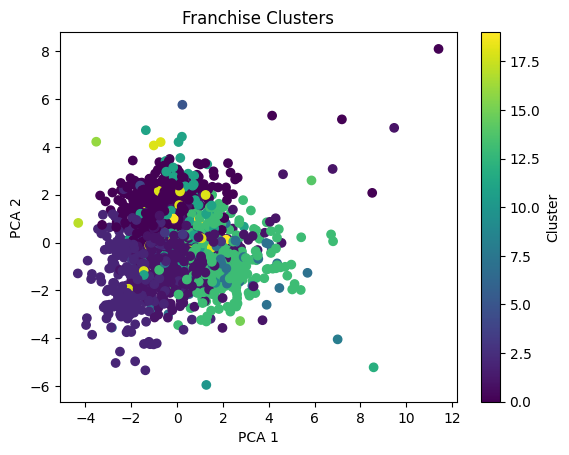

,collection_name,Cluster
9,Ocean's Collection,0
11,Predator Collection,0
4,Star Trek: The Original Series Collection,0
5,The Godfather Collection,0
6,The Dark Knight Collection,0
29,Rocky Collection,1
48,American Pie Collection,1
35,Evil Dead Collection,1
39,Torrente Collection,1
3,Three Colors Collection,1


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd



franchise_data_df = get_franchise_data(franchise_df)

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(franchise_data_df['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
franchise_data_df = pd.concat([franchise_data_df, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(franchise_data_df['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
franchise_data_df = pd.concat([franchise_data_df, country_df], axis=1)

franchise_data_df['oldest_release_year'] = franchise_data_df['oldest_release'].dt.year
franchise_data_df['newest_release_year'] = franchise_data_df['newest_release'].dt.year

# Fill NaN in the 'revenue_avg' column with 0
franchise_data_df['revenue_avg'] = franchise_data_df['revenue_avg'].fillna(0)



# Load and preprocess dat
data = franchise_data_df.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','revenue','country','region'])

# Drop rows where any other column contains NaN
data = data.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
franchise_data_df['Cluster'] = pd.NA  # Initialize Cluster column with NaN
franchise_data_df.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# print the 5 first franchises of each cluster
franchise_data_df.groupby('Cluster')[['collection_name','Cluster']].head(5).sort_values(by='Cluster')



In [31]:
print(average_stats['length_in_years'].shape)
print(average_stats['length_in_years_err'].shape)



(8,)
(8,)


Franchise of the cluster of less than 10 movies:
      Cluster                      collection_name
896         4                 Detonator Collection
19          5                James Bond Collection
12          6  The Chronicles of Narnia Collection
1275        8                      Alexandria Quad
1514        9                    The Koker Trilogy
751        10           Mi Nismo Anđeli Collection
1060       12                      Ukraine Trilogy
689        14                 The Raven Collection
303        15            The Musketeers Collection
414        16                  Anaconda Collection
314        17               Ghost Rider Collection
1227       19                    The Yusuf Trilogy
1274       19                Greek Tragedy Trilogy
1463       19            Evil (To Kako) Collection


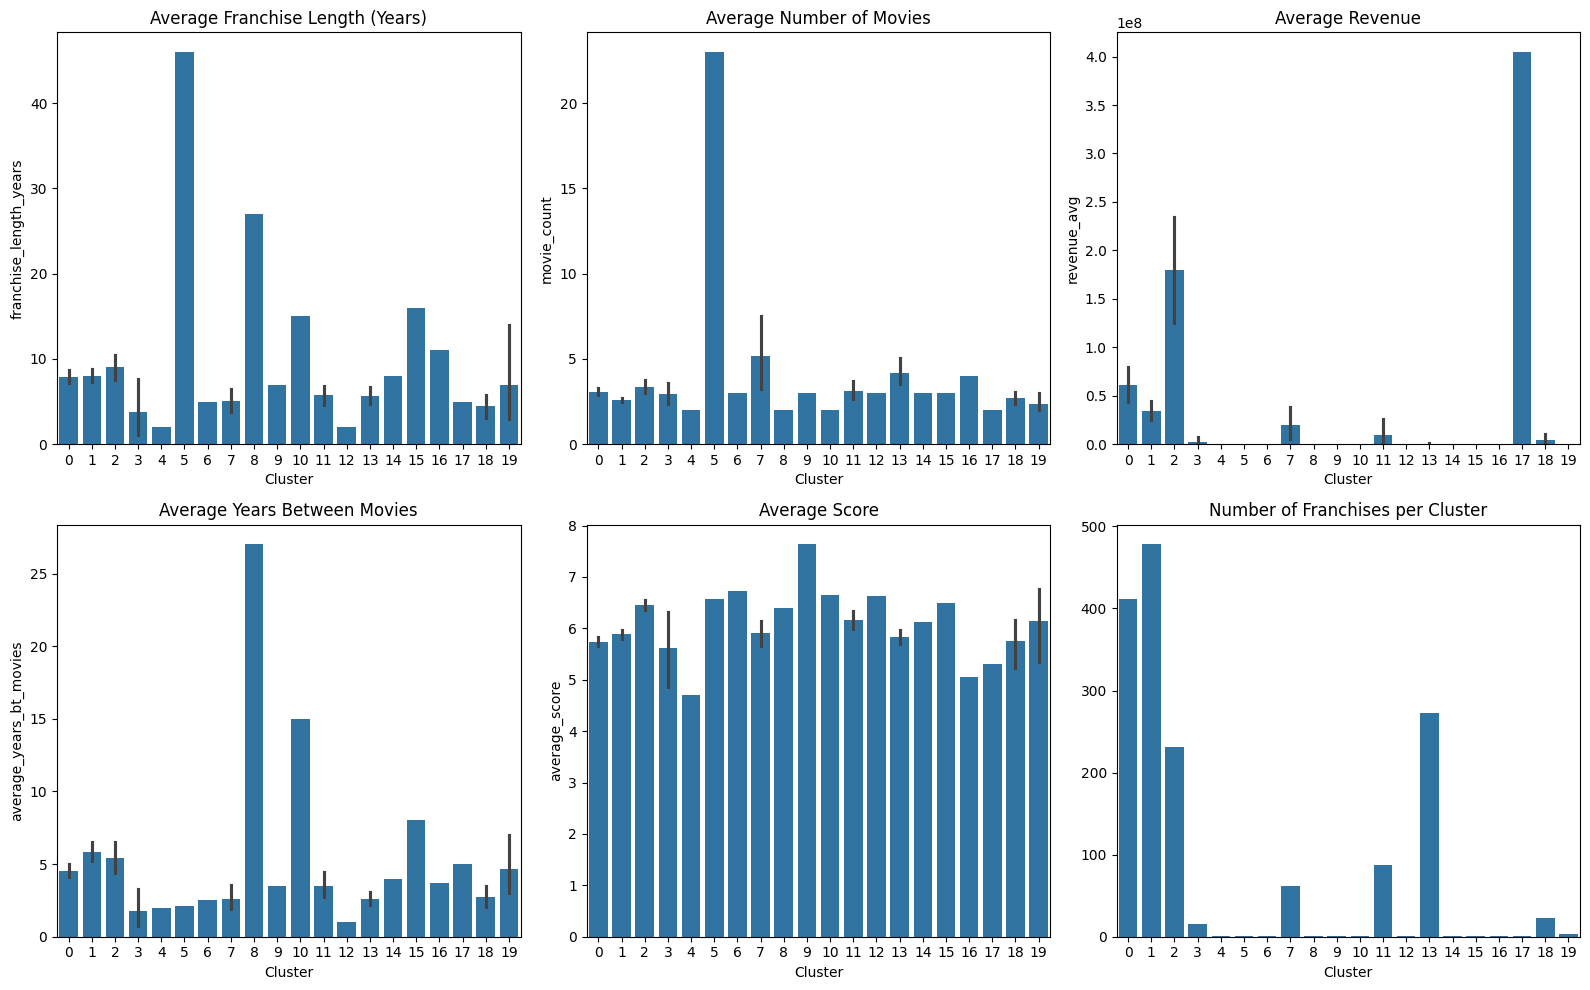

In [ ]:
# Drop the cluster with less than 10 franchises idk if it is necessary
franchise_data_df_filt = franchise_data_df.groupby('Cluster').filter(lambda x: len(x) >= 0)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(franchise_data_df[~franchise_data_df['Cluster'].isin(franchise_data_df.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(2, 3, figsize=(16, 10))
sns.barplot(x='Cluster', y='franchise_length_years', data=franchise_data_df_filt, ax=axs[0,0])
axs[0,0].set_title('Average Franchise Length (Years)')
sns.barplot(x='Cluster', y='movie_count', data=franchise_data_df_filt, ax=axs[0,1])
axs[0,1].set_title('Average Number of Movies')
sns.barplot(x='Cluster', y='revenue_avg', data=franchise_data_df_filt, ax=axs[0,2])
axs[0,2].set_title('Average Revenue')
sns.barplot(x='Cluster', y='average_years_bt_movies', data=franchise_data_df_filt, ax=axs[1,0])
axs[1,0].set_title('Average Years Between Movies')
sns.barplot(x='Cluster', y='average_score', data=franchise_data_df_filt, ax=axs[1,1])
axs[1,1].set_title('Average Score')
sns.barplot(x=franchise_data_df['Cluster'].value_counts().index, y=franchise_data_df['Cluster'].value_counts().values, ax=axs[1,2])
axs[1,2].set_title('Number of Franchises per Cluster')

plt.tight_layout()
plt.show()



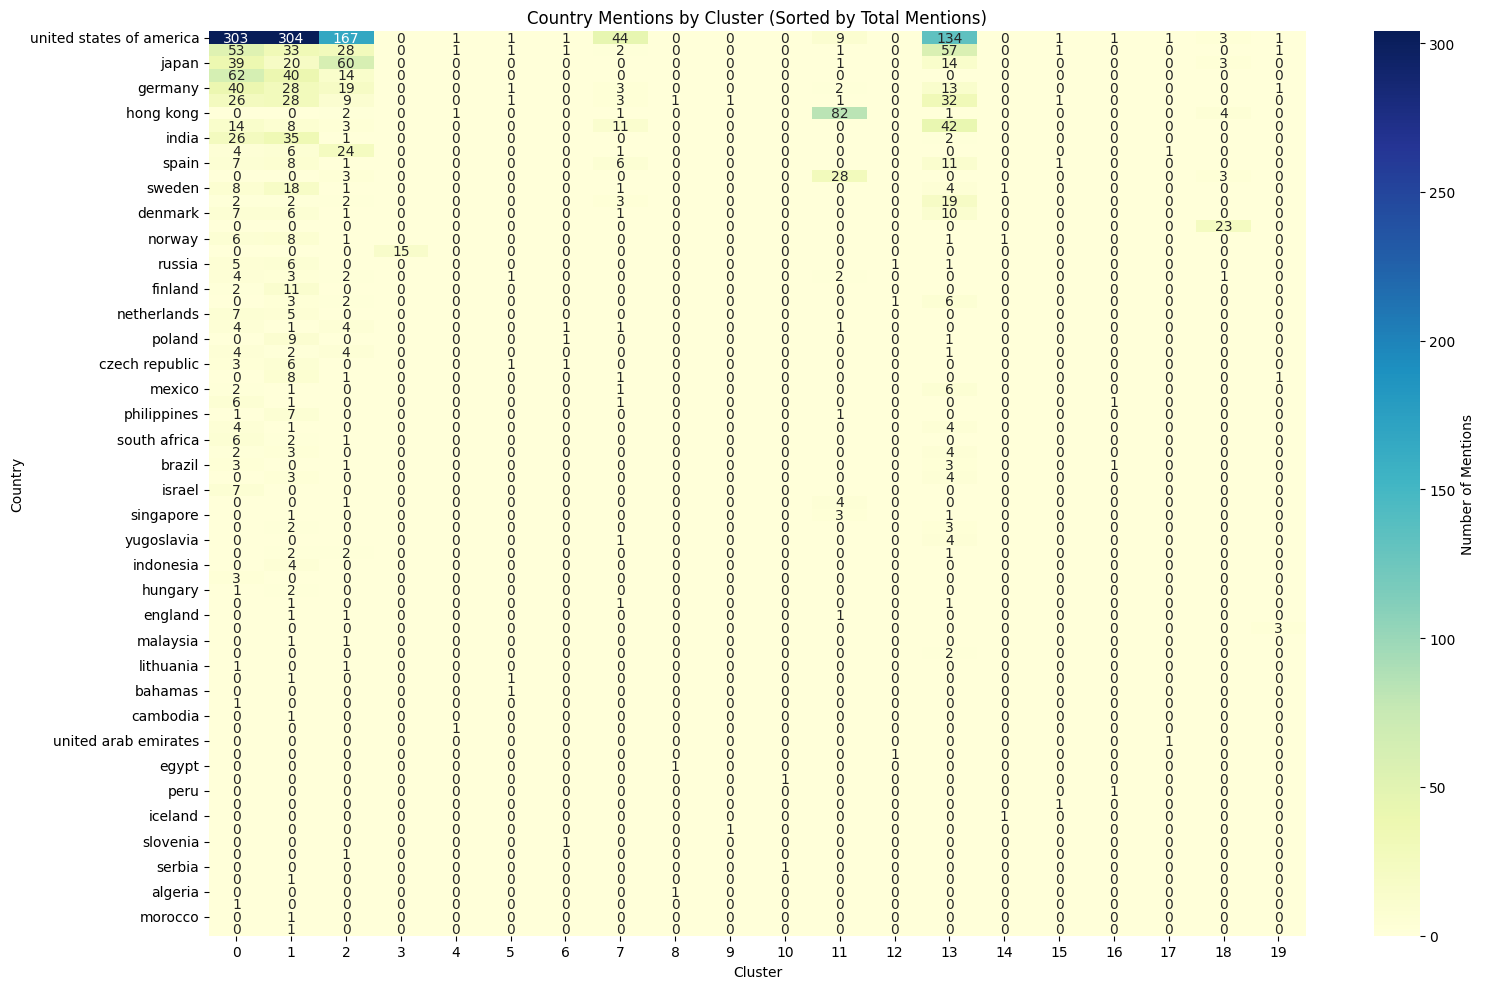

In [87]:
# Summing country mentions by cluster
country_sums = franchise_data_df.groupby('Cluster')[
    [col for col in franchise_data_df.columns if col.startswith('country_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums.columns = country_sums.columns.str.replace('country_', '')

# Sort countries by total mentions (sum across clusters)
country_sums = country_sums.loc[:, country_sums.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(16, 10))  # Adjust size to fit all countries
sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'}
)
plt.title('Country Mentions by Cluster (Sorted by Total Mentions)')
plt.xlabel('Cluster')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


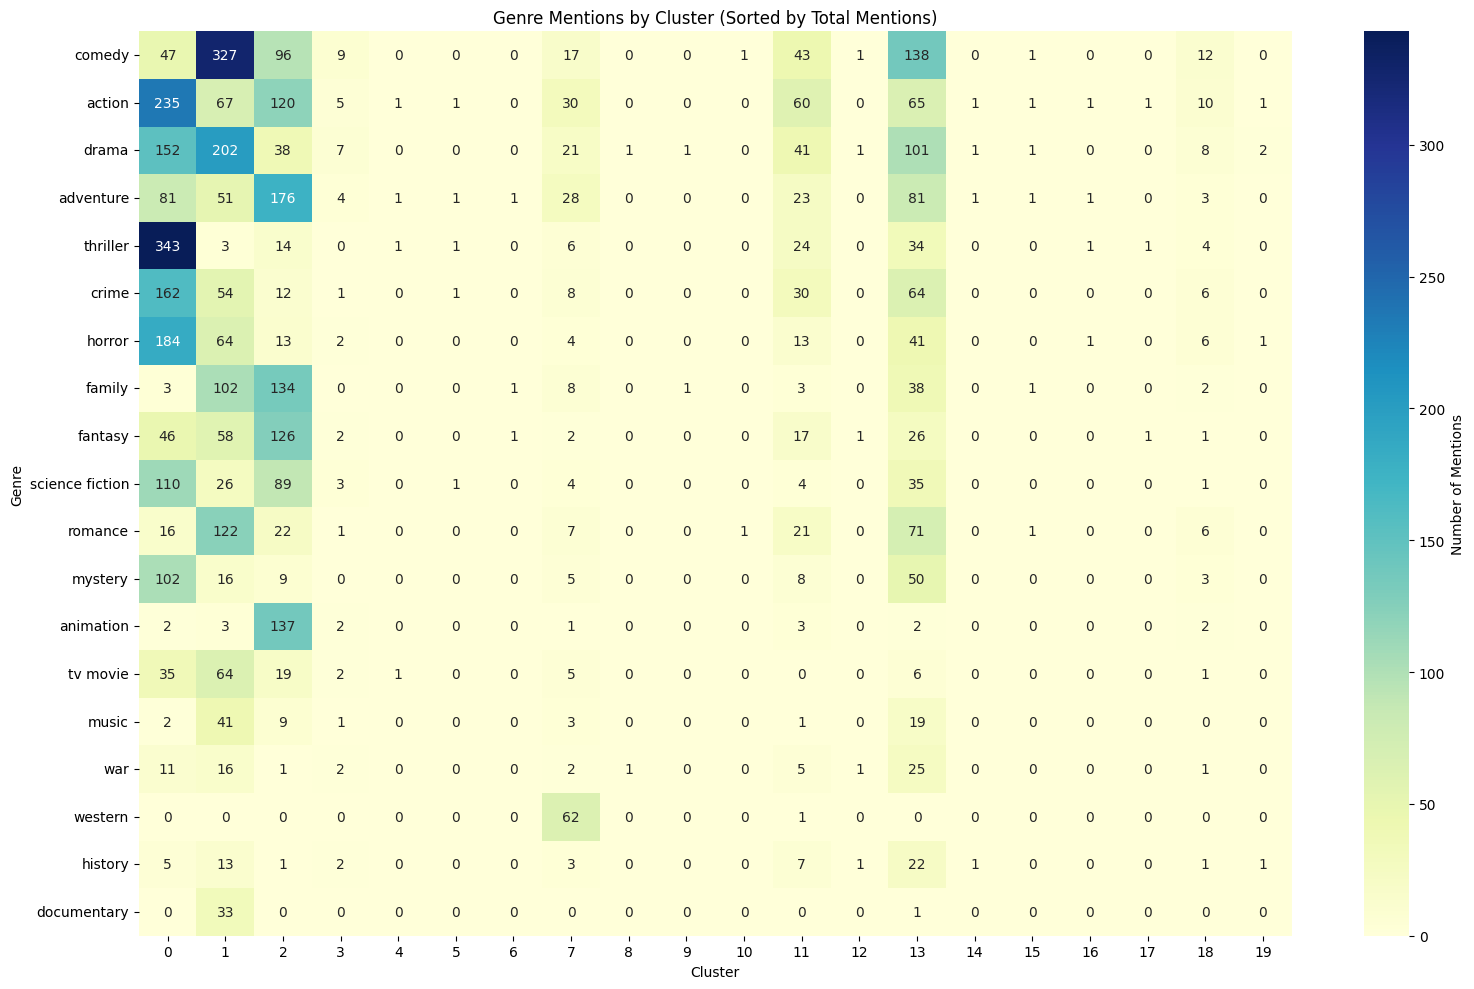

In [86]:
# Summing genre mentions by cluster
genre_sums = franchise_data_df.groupby('Cluster')[
    [col for col in franchise_data_df.columns if col.startswith('genre_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums.columns = genre_sums.columns.str.replace('genre_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums = genre_sums.loc[:, genre_sums.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(16, 10))  # Adjust size to fit all genres
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'}
)
plt.title('Genre Mentions by Cluster (Sorted by Total Mentions)')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


# Unsupervised learning

To understand better what makes a good franchise, we're going to try to group the franchise that are similar to then have more information on what's the common feature that makes franchise perform a certain ways

### With the franchise that have a ratio

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_22826/2277557813.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

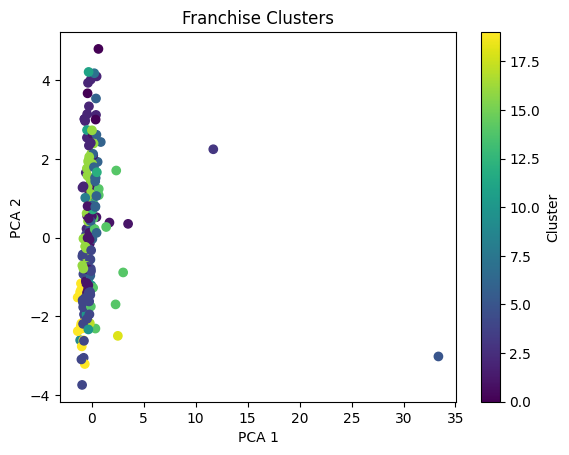

,collection_name,Cluster
92,Friday the 13th Collection,0
817,Living Dead Collection,0
16,The Terminator Collection,0
42,Jaws Collection,1
37,The Grudge Collection,1
35,Evil Dead Collection,1
27,28 Days/Weeks Later Collection,1
20,Saw Collection,1
0,Star Wars Collection,2
7,Back to the Future Collection,2


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd



KNN_data = get_franchise_data(franchise_df)
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(KNN_data['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(KNN_data['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, country_df], axis=1)

# Separate the franchise with a ratio of revenue over budget and the ones that don't
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])
KNN_data_na = KNN_data[KNN_data['ratio_rb'].isna()]

# Load and preprocess dat
data = KNN_data_no_na.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','country','region'])

# Drop rows where any other column contains NaN
data = data.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_data_no_na['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_data_no_na.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# print the 5 first franchises of each cluster
KNN_data_no_na.groupby('Cluster')[['collection_name','Cluster']].head(5).sort_values(by='Cluster')



Franchise of the cluster of less than 10 movies:
     Cluster                        collection_name
16         0              The Terminator Collection
817        0                 Living Dead Collection
92         0             Friday the 13th Collection
150        3              The Millennium Collection
34         5  USA: Land of Opportunities Collection
40         7                  Underworld Collection
314        8                 Ghost Rider Collection
219        9                   Peter Pan Collection
220        9                    Fantasia Collection
77        10               Wayne's World Collection
256       10               Dirty Dancing Collection
258       10                      Grease Collection
259       10                     Step Up Collection
399       10                  Sister Act Collection
446       10          The Blues Brothers Collection
1561      10                 Purple Rain Collection
300       11         Mission: Impossible Collection
33        11   

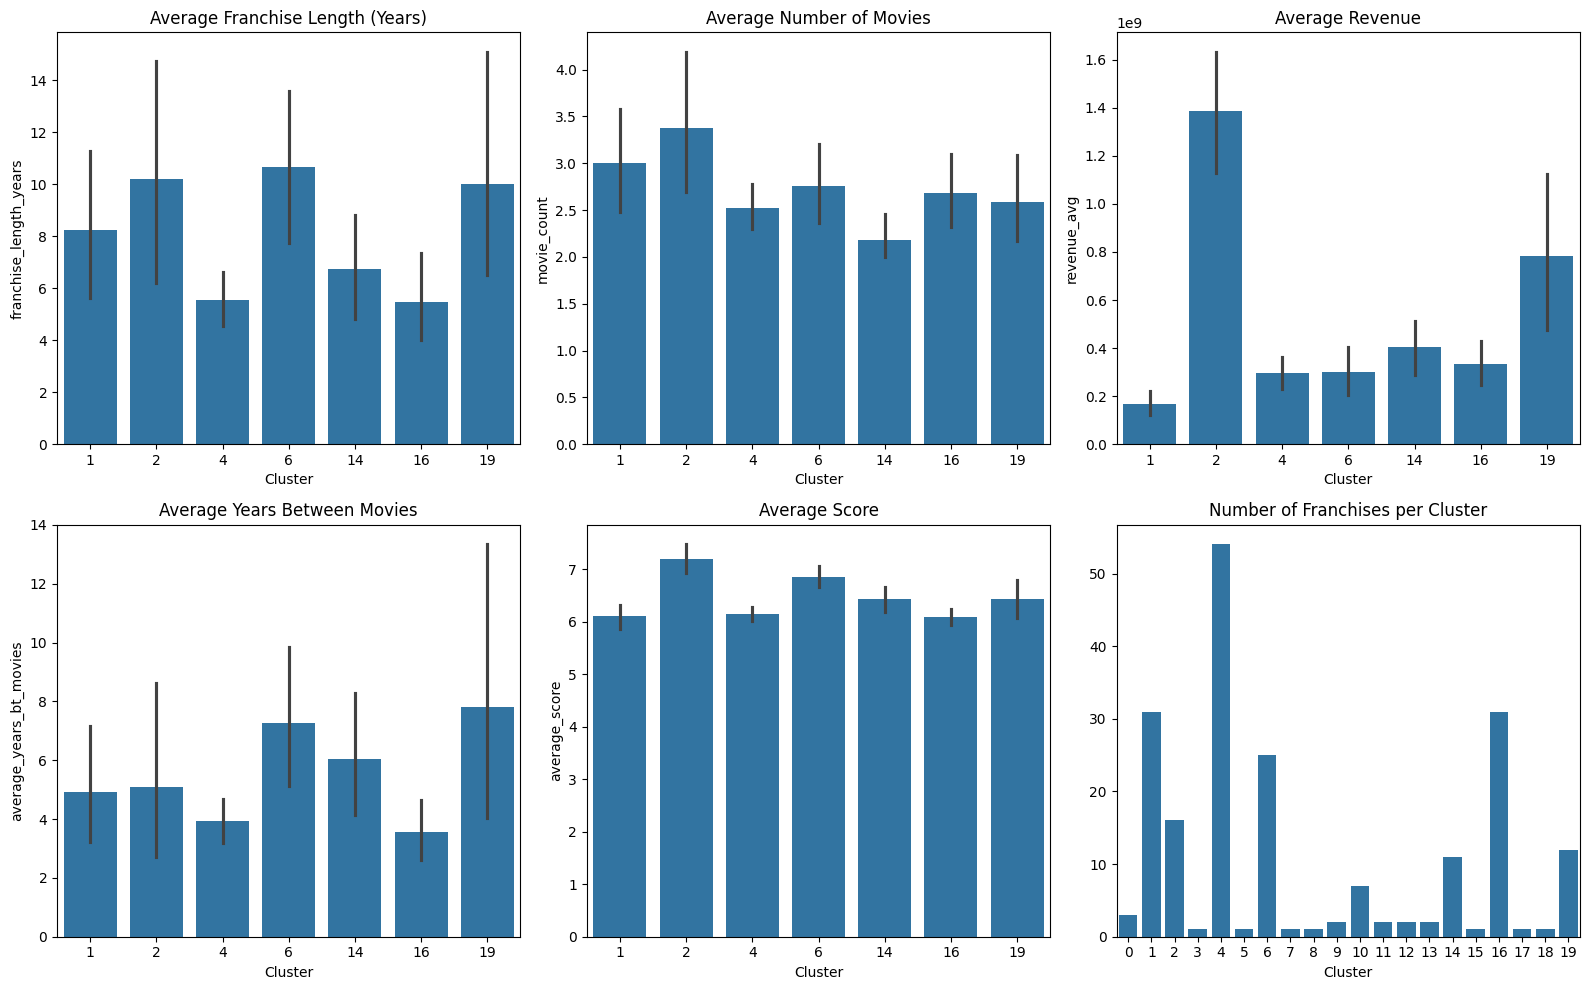

In [ ]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_data_filt = KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_data_no_na[~KNN_data_no_na['Cluster'].isin(KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(2, 3, figsize=(16, 10))
sns.barplot(x='Cluster', y='franchise_length_years', data=KNN_data_filt, ax=axs[0,0])
axs[0,0].set_title('Average Franchise Length (Years)')
sns.barplot(x='Cluster', y='movie_count', data=KNN_data_filt, ax=axs[0,1])
axs[0,1].set_title('Average Number of Movies')
sns.barplot(x='Cluster', y='revenue_avg', data=KNN_data_filt, ax=axs[0,2])
axs[0,2].set_title('Average Revenue')
sns.barplot(x='Cluster', y='average_years_bt_movies', data=KNN_data_filt, ax=axs[1,0])
axs[1,0].set_title('Average Years Between Movies')
sns.barplot(x='Cluster', y='average_score', data=KNN_data_filt, ax=axs[1,1])
axs[1,1].set_title('Average Score')
sns.barplot(x=KNN_data_no_na['Cluster'].value_counts().index, y=KNN_data_no_na['Cluster'].value_counts().values, ax=axs[1,2])
axs[1,2].set_title('Number of Franchises per Cluster')

plt.tight_layout()
plt.show()



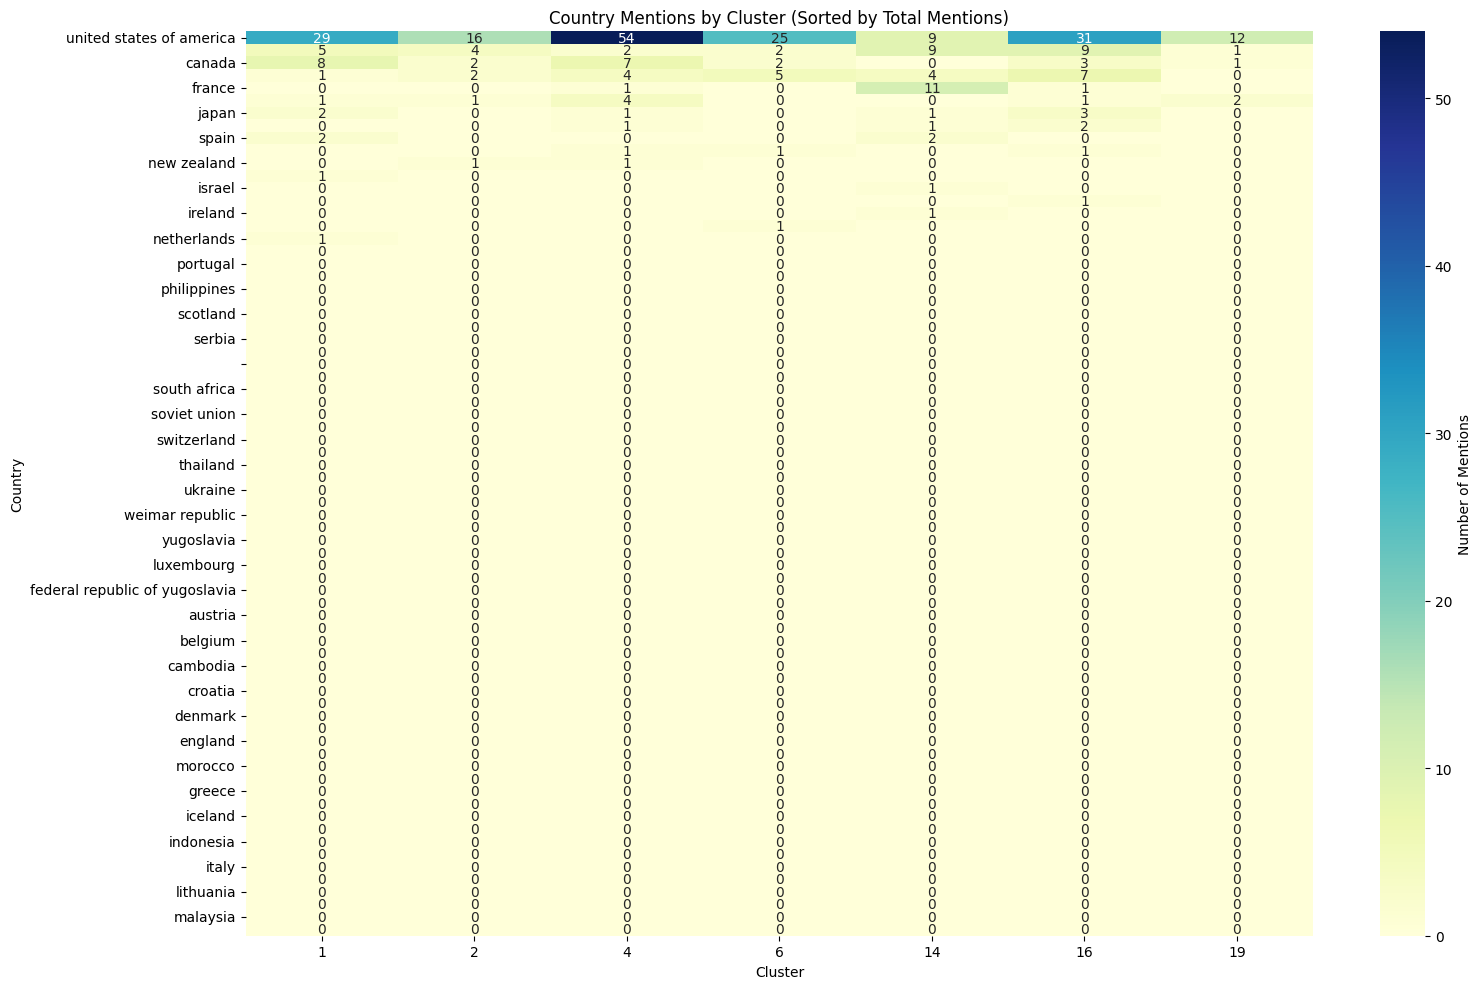

In [ ]:
# Summing country mentions by cluster
country_sums = franchise_data_df_filt.groupby('Cluster')[
    [col for col in franchise_data_df_filt.columns if col.startswith('country_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums.columns = country_sums.columns.str.replace('country_', '')

# Sort countries by total mentions (sum across clusters)
country_sums = country_sums.loc[:, country_sums.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(16, 10))  # Adjust size to fit all countries
sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'}
)
plt.title('Country Mentions by Cluster (Sorted by Total Mentions)')
plt.xlabel('Cluster')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


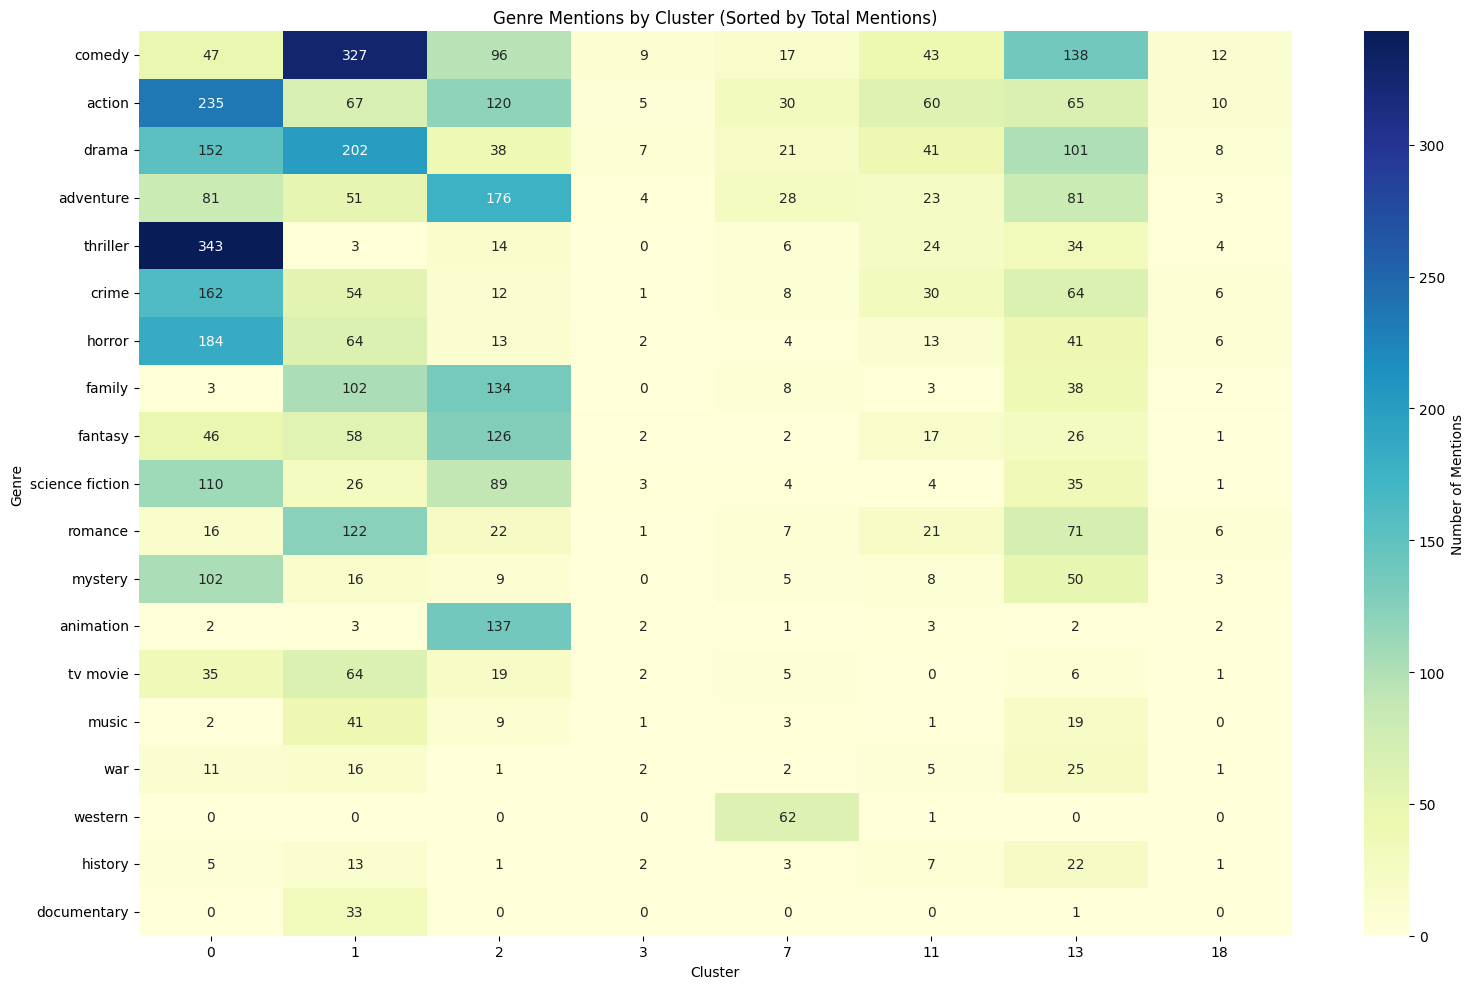

In [ ]:
# Summing genre mentions by cluster
genre_sums = franchise_data_df_filt.groupby('Cluster')[
    [col for col in franchise_data_df_filt.columns if col.startswith('genre_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums.columns = genre_sums.columns.str.replace('genre_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums = genre_sums.loc[:, genre_sums.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(16, 10))  # Adjust size to fit all genres
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'}
)
plt.title('Genre Mentions by Cluster (Sorted by Total Mentions)')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


### With the franchise that dont have a ratio for revenue and budget

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_22826/1422980268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KNN_data_na['Cluster'] = pd.NA  # Initialize Cluster column with NaN


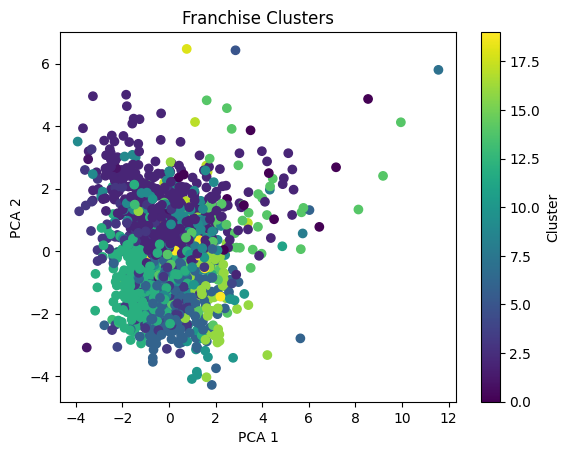

,collection_name,Cluster
386,Vares Collection,0
580,Bananas!* Collection,0
600,Uuno Turhapuro Collection,0
419,Osobennosti Natsionalnoy ... - Collection,0
281,Arn Collection,0
...,...,...
533,Recep Ivedik Collection,19
1091,Hababam Sınıfı Collection,19
1116,G.O.R.A. Collection,19
1202,Vizontele [Seri],19


In [ ]:

# Load and preprocess dat
data = KNN_data_na.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','country','region','revenue_avg','budget_avg','ratio_rb'])

# Drop rows where any other column contains NaN
data = data.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_data_na['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_data_na.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# print the 5 first franchises of each cluster
KNN_data_na.groupby('Cluster')[['collection_name','Cluster']].head(5).sort_values(by='Cluster')



In [ ]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_data_filt = KNN_data_na.groupby('Cluster').filter(lambda x: len(x) >= 10)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(franchise_data_df[~franchise_data_df['Cluster'].isin(franchise_data_df.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(2, 3, figsize=(16, 10))
sns.barplot(x='Cluster', y='franchise_length_years', data=KNN_data_filt, ax=axs[0,0])
axs[0,0].set_title('Average Franchise Length (Years)')
sns.barplot(x='Cluster', y='movie_count', data=KNN_data_filt, ax=axs[0,1])
axs[0,1].set_title('Average Number of Movies')
sns.barplot(x='Cluster', y='revenue_avg', data=KNN_data_filt, ax=axs[0,2])
axs[0,2].set_title('Average Revenue')
sns.barplot(x='Cluster', y='average_years_bt_movies', data=KNN_data_filt, ax=axs[1,0])
axs[1,0].set_title('Average Years Between Movies')
sns.barplot(x='Cluster', y='average_score', data=KNN_data_filt, ax=axs[1,1])
axs[1,1].set_title('Average Score')
sns.barplot(x=franchise_data_df['Cluster'].value_counts().index, y=franchise_data_df['Cluster'].value_counts().values, ax=axs[1,2])
axs[1,2].set_title('Number of Franchises per Cluster')

plt.tight_layout()
plt.show()

